In [12]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import get_from_config
import fur.path_assistant as path_assistant
shift = path_assistant.PathAssistant('shift_03_16_2020')
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')
N_to_I = 1/sum_channel_to_photoelectrons/cur_to_sum_channel
meas_FLAT = pd.read_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'), index_col=0)
meas_FLAT = meas_FLAT[meas_FLAT['N']<2.4e7]
meas_FLAT = meas_FLAT.sort_values(by='N',ignore_index=True)

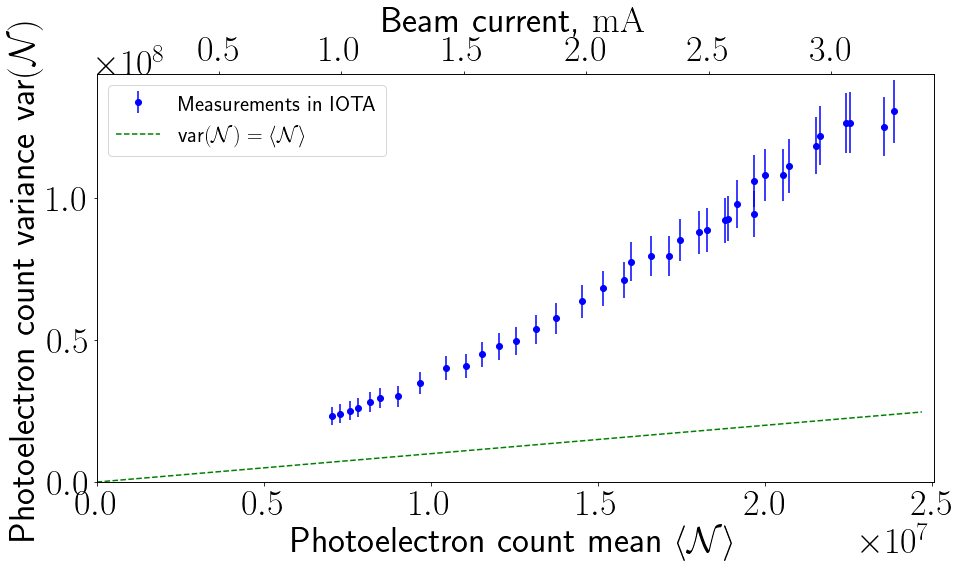

In [13]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 36,'legend.fontsize':22})
colors = {"FLAT": 'blue'}

fig, ax = plt.subplots(figsize=(15, 7.5))
ax.errorbar(meas_FLAT['N'],meas_FLAT['varN'],marker='o',linestyle='None',yerr=meas_FLAT['errorbar'],color='b',
            label = r'Measurements in IOTA')
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_xlim(0, 1.05*meas_FLAT['N'].max())
ax.set_ylim(0, 1.1*meas_FLAT['varN'].max())
ax1 = ax.twiny()
ax1.set_xlabel('Beam current, \SI{}{mA}')
ax1.set_xlim(N_to_I*np.asarray(ax.get_xlim()))
ax1.set_xticks(ticks=ax1.get_xticks()[1:-1])
plt.show()

In [14]:
df = pd.read_csv("M_on_grid_precalc.csv", index_col=0)

In [15]:
eys = df.columns.values.astype(np.float64)

In [16]:
eys

array([0.005     , 0.00777778, 0.01055556, 0.01333333, 0.01611111,
       0.01888889, 0.02166667, 0.02444444, 0.02722222, 0.03      ])

In [17]:
def reconstruct_ey(avN, varN):
    Mexp = avN**2/(varN-avN)
    return np.interp(Mexp,df.loc[avN,:],eys)

In [18]:
reconstruct_ey(meas_FLAT['N'][0], meas_FLAT['varN'][0])

0.010379989668889998

In [19]:
meas_FLAT['ey_rec'] = meas_FLAT.apply(
    lambda row: reconstruct_ey(*row[['N', 'varN']]), axis=1)
# meas_FLAT['varNtop'] = meas_FLAT['varN']+meas_FLAT['errorbar']
# meas_FLAT['varNbottom'] = meas_FLAT['varN']-meas_FLAT['errorbar']
# meas_FLAT['Sigma_um_Y_Meas_Top'] = meas_FLAT.apply(
#     lambda row: reconstruct_sy(*row[['N', 'varNbottom', 'Sigma_um_X', 'N:IWCMBE']]), axis=1)-meas_FLAT['Sigma_um_Y_Meas']
# meas_FLAT['Sigma_um_Y_Meas_Bottom'] = -meas_FLAT.apply(
#     lambda row: reconstruct_sy(*row[['N', 'varNtop', 'Sigma_um_X', 'N:IWCMBE']]), axis=1)+meas_FLAT['Sigma_um_Y_Meas']

In [20]:
meas_FLAT['I_mA'] = meas_FLAT['N']*N_to_I

In [21]:
meas_FLAT['ey_rec']

0     0.010380
1     0.011260
2     0.011980
3     0.012290
4     0.011872
5     0.012192
6     0.016231
7     0.014234
8     0.013148
9     0.016880
10    0.015435
11    0.015724
12    0.017406
13    0.017280
14    0.017296
15    0.016904
16    0.017170
17    0.018831
18    0.015272
19    0.017593
20    0.021184
21    0.018792
22    0.020560
23    0.021651
24    0.022668
25    0.022903
26    0.020798
27    0.026846
28    0.018708
29    0.019078
30    0.022168
31    0.021069
32    0.021299
33    0.019914
34    0.021597
35    0.022115
36    0.028639
37    0.026906
Name: ey_rec, dtype: float64

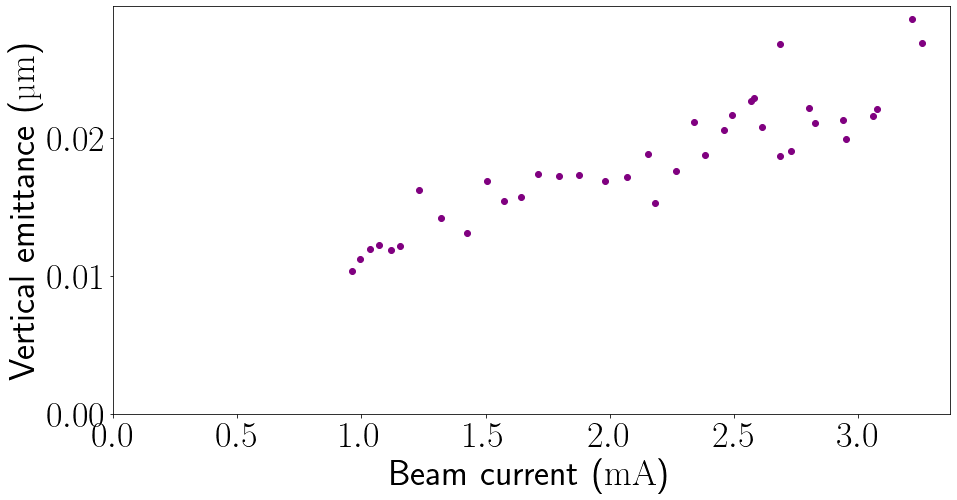

In [22]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 36,'legend.fontsize':22})
fig, ax = plt.subplots(figsize=(15, 7.5))
yerr = 0#[meas_FLAT['Sigma_um_Y_Meas_Bottom'], meas_FLAT['Sigma_um_Y_Meas_Top']]
ax.errorbar(meas_FLAT['I_mA'], meas_FLAT['ey_rec'], marker='o', linestyle='None',
            color='purple', yerr=yerr)
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel('Beam current (\SI{}{mA})')
ax.set_ylabel('Vertical emittance (\SI{}{\micro m})')
plt.show()

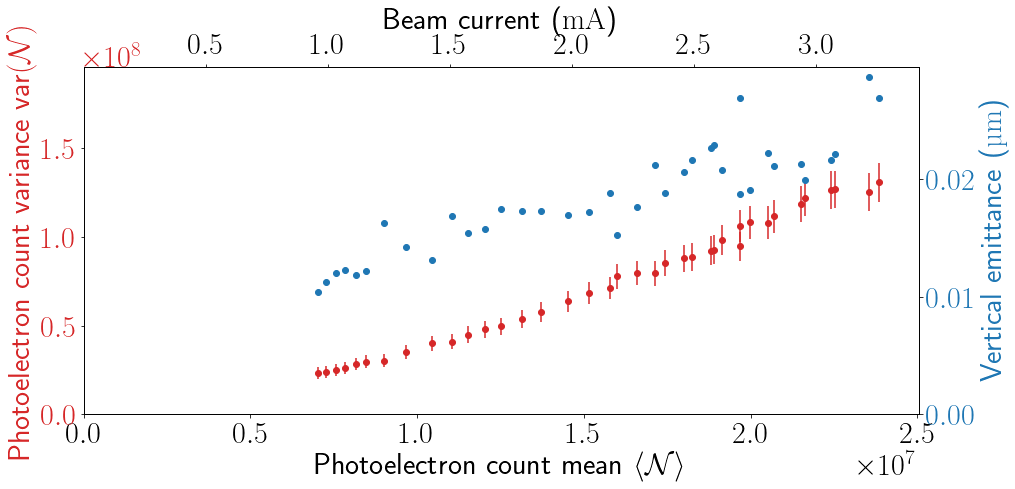

In [23]:
plt.rcParams.update({'font.size': 30,'legend.fontsize':22})

fig, ax1 = plt.subplots(figsize=[15, 7.5])

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.errorbar(meas_FLAT['N'],meas_FLAT['varN'],marker='o',linestyle='None',
             yerr=meas_FLAT['errorbar'],color=color,
             label = r'Measurements in IOTA')

ax1.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$",
               color=color)
ax1.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax1.set_xlim(0, 1.05*meas_FLAT['N'].max())
ax1.set_ylim(0, 1.5*meas_FLAT['varN'].max())

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Vertical emittance (\SI{}{\micro m})', color=color)
# we already handled the x-label with ax1
yerr = 0
#[meas_FLAT['Sigma_um_Y_Meas_Bottom'], meas_FLAT['Sigma_um_Y_Meas_Top']]
ax2.errorbar(meas_FLAT['N'], meas_FLAT['ey_rec'],
             marker='o', linestyle='None',
             color=color, yerr=yerr)
ax2.set_xlim(0, ax2.get_xlim()[1])
ax2.set_ylim(0, ax2.get_ylim()[1])
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twiny()
ax3.set_xlabel('Beam current (\SI{}{mA})')
ax3.set_xlim(N_to_I*np.asarray(ax1.get_xlim()))
ax3.set_xticks(ticks=ax3.get_xticks()[1:-1])
plt.savefig(shift.get_results_dir().fi("size_reconstruction.png"),
            dpi=300, bbox_inches='tight')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()

In [24]:
import figure_arrange_scripts as ff
hor_separ = 0.05
v_space = 100
fontsize = 200
im_paths = [shift.get_results_dir().fi("round_beam.png"),
            shift.get_results_dir().fi("size_reconstruction.png")]
output_path = path_assistant.get_PRL_images_dir().fi("iota_measurements.png")

Result saved to /home/ilobach/FUR_Run2_experiment_paper/images/iota_measurements.png


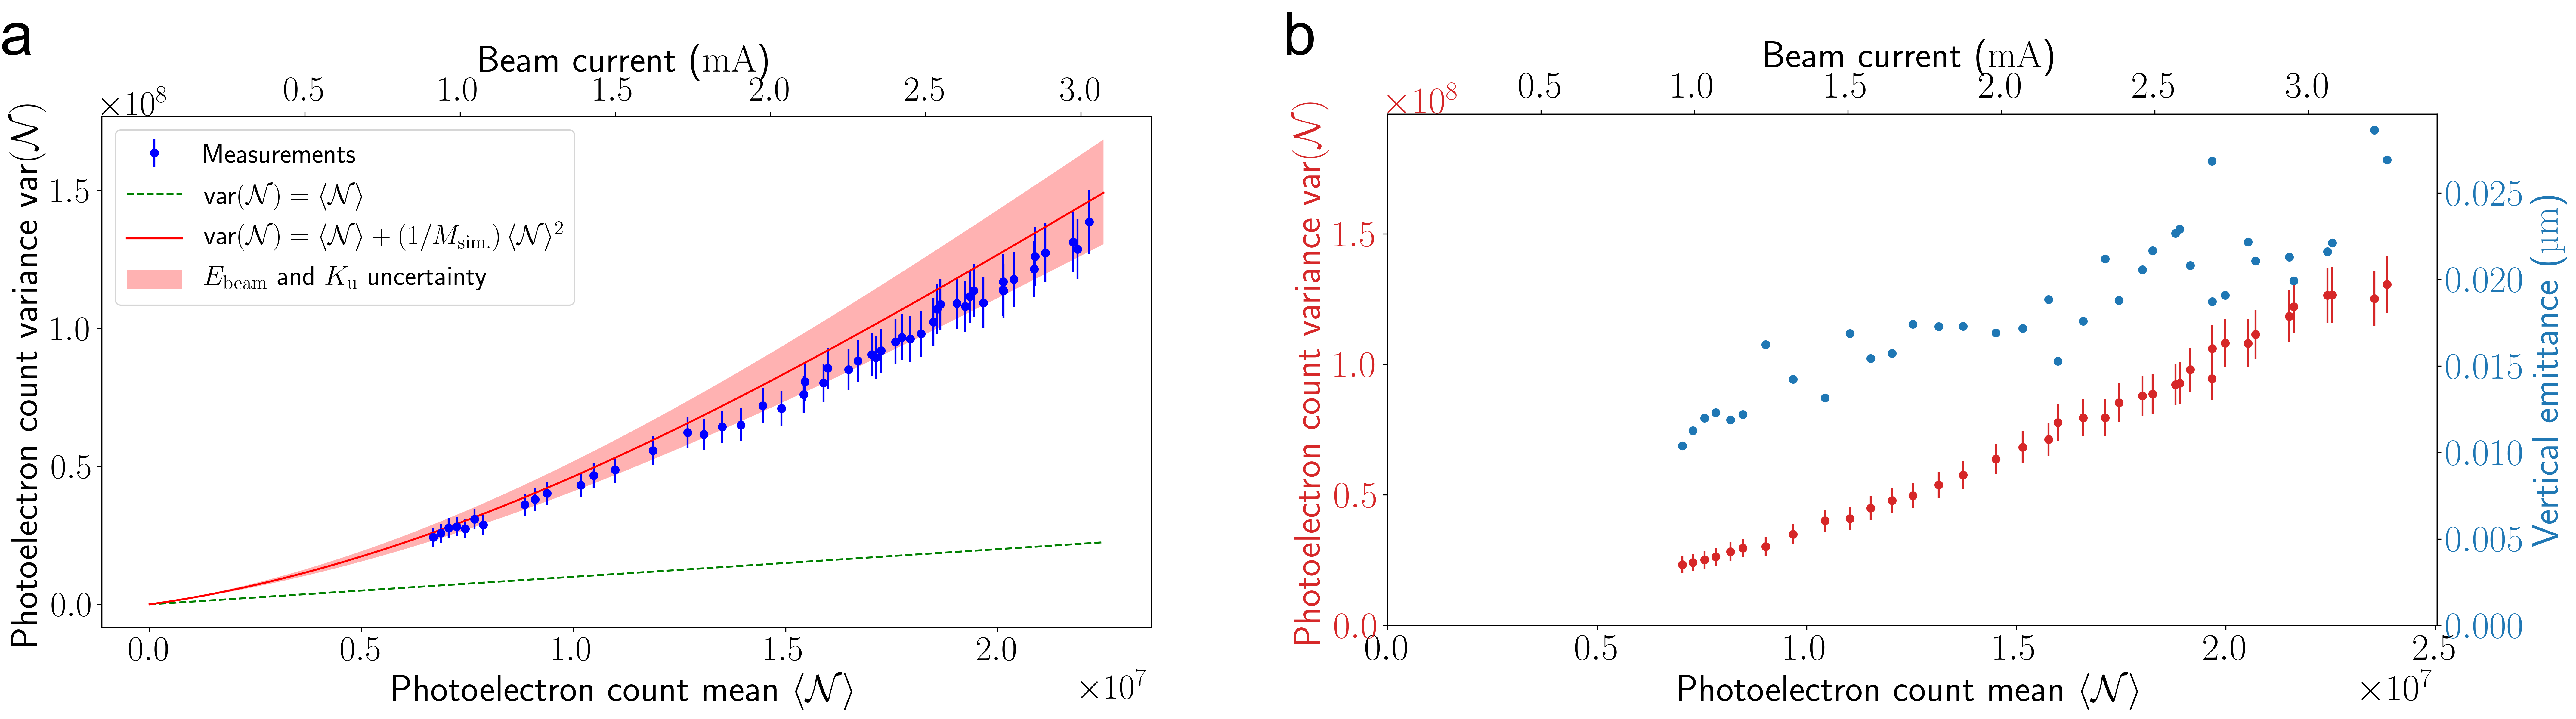

In [25]:
ff.RowOfFigures(im_paths,output_path,
                hor_separ,v_space,fontsize,display_inline=1)